In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import iris as ir
import iris.coord_categorisation
import iris.plot as iplt
import cftime as cf

/home/dennisonfw/miniconda2/envs/notebk/lib/python2.7/site-packages/cf_units/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from cf_units import _udunits2 as _ud
/home/dennisonfw/miniconda2/envs/notebk/lib/python2.7/site-packages/cartopy/crs.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from cartopy._crs import CRS, Geodetic, Globe, PROJ4_VERSION
/home/dennisonfw/miniconda2/envs/notebk/lib/python2.7/site-packages/cartopy/geodesic/__init__.py:21: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from cartopy.geodesic._geodesic import Geodesic  # noqa: F401


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# sensitivity runs
runs = ['control','shi','newcoeff','newbr_only','new_br']
lab = ['Cont','Shi 2001','New Coeff.','Br','All']
path = '/nesi/nobackup/dennisonfw/output/netcdf'

clist = [] #daily
for runname in runs :
        x = ir.load_cube(path+'/an974/an974_'+runname+'_tco.nc')
        clist.append(x)

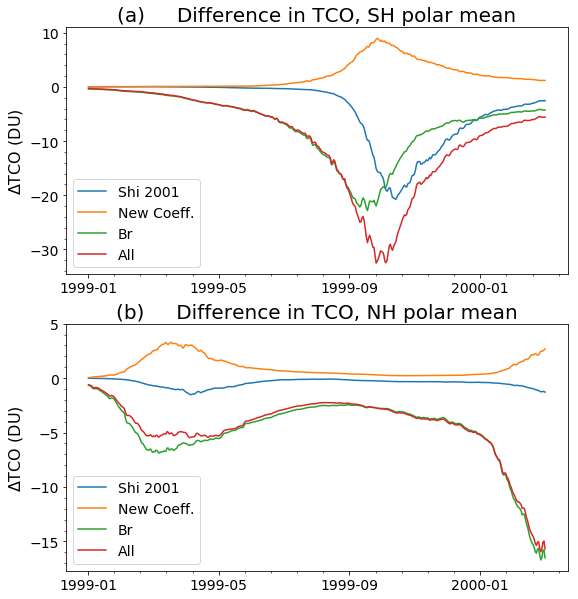

In [6]:
# Figure 3 

def plot_sens(lat_range, ttl, ax, ylm) :
    plt.subplot(ax)
    constr_lat = ir.Constraint(latitude = lat_range)
    o3cont_ex = clist[0].extract(constr_lat)
    grid_areas_o3 = iris.analysis.cartography.area_weights(o3cont_ex)
    o3cont_ts = o3cont_ex.collapsed(['longitude','latitude'],ir.analysis.MEAN, weights=grid_areas_o3)

    idx = [1,2,3,4]
    o3_tot = o3cont_ts 
    for ii in idx :     #enumerate(clist)
        o3_ex = clist[ii].extract(constr_lat)
        o3_ts = o3_ex.collapsed(['longitude','latitude'],ir.analysis.MEAN, weights=grid_areas_o3)
        iplt.plot(o3_ts - o3cont_ts[0:len(o3_ts.data)], label=lab[ii]) #
        o3_tot = o3_tot + o3_ts - o3cont_ts[0:len(o3_ts.data)]

    ## plot sum sensitivity runs    
    #iplt.plot(o3_tot-o3_ts , label='Sum')    
    plt.yticks(ylm)
    plt.minorticks_on()
    plt.ylabel(r"$\Delta$TCO (DU)",fontsize=16)
    plt.title (ttl,fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=14)


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(9,10))
plot_sens(lambda cell: cell <= -65,'(a)     Difference in TCO, SH polar mean',ax1,range(-30,20,10))
plot_sens(lambda cell: cell >= 65,'(b)     Difference in TCO, NH polar mean',ax2,range(-15,10,5))

plt.show()
#plt.savefig('figs/Ozone_Sensitivity.png',bbox_inches='tight')

In [7]:
# long runs
runs = ['_new_br','']  
lab = ['New Het.','Control','NIWA/Bodeker']

clist = [] #daily
mmlist = [] #monthly mean
x = ir.load_cube(path+'/aw638/aw638_new_br_tco_mm.nc')
x.remove_coord('forecast_period')
mmlist.append(x)

x = ir.load_cube(path+'/aw638/aw638_new_br_tco.nc')
x.remove_coord('forecast_period')
clist.append(x)

x = ir.load_cube(path+'/aw638/aw638_tco_mm.nc')
x.remove_coord('forecast_period')
mmlist.append(x)
x = ir.load_cube(path+'/aw638/aw638_tco.nc')
x.remove_coord('forecast_period')
clist.append(x)

In [37]:
# NIWA/Bodeker total column ozone (vn3.4 unpatched)
# from: http://www.bodekerscientific.com/data/total-column-ozone

from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes
def load_bodtco(year1,year2,**kwargs) : 
    bodpath = '/nesi/nobackup/dennisonfw/bodekerozone/'
    if 'freq' in kwargs :
        if kwargs['freq']=='daily':
                tcobod = ir.load(bodpath+'TCOdaily/V3.4/NIWA-BS_CombinedTCO_V3.4_*',
                                 'equivalent_thickness_at_stp_of_atmosphere_ozone_content')
    else :        
        tcobod = ir.load(bodpath+'NIWA-BS_CombinedTCO_V3.4_*',
                         'equivalent_thickness_at_stp_of_atmosphere_ozone_content')
  
    equalise_attributes(tcobod)
    unify_time_units(tcobod)
    tcobod = tcobod.concatenate()[0]
    
    tcobod.coord('latitude').guess_bounds()
    tcobod.coord('longitude').guess_bounds()

    ir.coord_categorisation.add_season(tcobod,'time','season')
    ir.coord_categorisation.add_year(tcobod, 'time', name='year')
    ir.coord_categorisation.add_month_number(tcobod, 'time', name='month_number')
    ir.coord_categorisation.add_month(tcobod, 'time', name='month')

    # mask missing values
    msk=np.array(tcobod.data)
    msk[msk!=-999]=0
    msk[msk==-999.0]=1
    msk[msk==np.nan]=1
    import numpy.ma as ma
    tcobod.data = ma.array(tcobod.data, mask=msk)

    year_range = lambda cell: year1 <= cell <= year2
    tcobod = tcobod.extract(ir.Constraint(year=year_range))
    
    return tcobod;

bod_m = load_bodtco(1996,2010)
bod_d = load_bodtco(1979,2016,freq='daily')

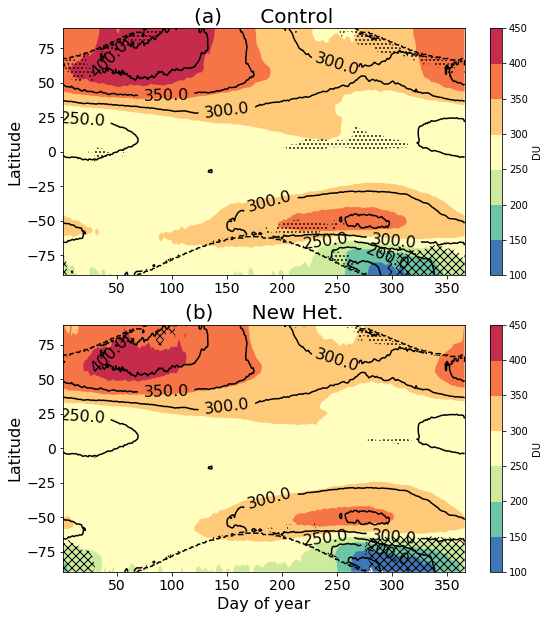

In [13]:
# Figure 4

def stretch_360(cube1,cube2) :
    cube1_temp = cube1.copy()
    cube1_temp.remove_coord('season')
    cube1_temp.remove_coord('month')
    cube1_temp.coord('doy').points = (cube1_temp.coord('doy').points * 365./360.).astype(np.float32)
    intpoints = [('doy',list(cube2.coord('doy').points.astype(np.float32))),
              ('latitude',cube2.coord('latitude').points)]

    cube1_stretch = cube1_temp.interpolate(intpoints, ir.analysis.Linear())
    return cube1_stretch
      
def zm_clim(cube) :
    try :
        ir.coord_categorisation.add_day_of_year(cube, 'time', name='doy')
    except :
        print('')
    dummycube = cube.extract(ir.Constraint(year=1996)).collapsed('longitude',ir.analysis.MEAN)
    zm = cube.extract(ir.Constraint(year=range(1996,2010))).collapsed('longitude',ir.analysis.MEAN)
    
    zmclim = dummycube.copy(data=zm.aggregated_by('doy',ir.analysis.MEAN).data)
    zmclim_sd = dummycube.copy(data=zm.aggregated_by('doy',ir.analysis.STD_DEV).data)
    
    return zmclim, zmclim_sd
    
def plot_zm_clim(cube1,cube2):
    zm1clim, sd1 = zm_clim(cube1)
    zm2clim, sd2 = zm_clim(cube2)
    
    zm1clim_s = stretch_360(zm1clim,zm2clim) 
    
    v = range(100,500,50)
    zm1clim_s.coord('time').points = zm2clim.coord('time').points
    iplt.contourf(zm1clim_s, v, coords=['doy','latitude']) 
    cbar = plt.colorbar(label = 'DU')
    cs = iplt.contour(zm2clim, v, coords=['doy','latitude'], colors='k')    # 
    plt.clabel(cs, inline=1, fontsize=16, fmt='%3.1f',)
        
    hatch = plt.contourf(zm1clim_s.coord('doy').points,zm1clim_s.coord('latitude').points,
                         ((zm1clim_s.data-zm2clim.data)).T,   #/sd2.data
                          [-1000,-30,30,1000], hatches=['xxx','','...'], colors='k', alpha=0)
    
    # dashed line for absence of observations
    nans = zm2clim.copy(data = zm2clim.data.data) # copy without mask
    iplt.contour(nans,[-2,0], coords=['doy','latitude'], colors='k', linestyles='--')
    
    plt.ylabel('Latitude', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    return zm1clim_s, zm2clim 

fig, ax = plt.subplots(2,1,figsize=(9,10))
plt.set_cmap('Spectral_r')
plt.subplot(2,1,1)
plot_zm_clim(clist[1],bod_d) 
plt.title('(a)      Control', fontsize=20)

plt.subplot(2,1,2)
plot_zm_clim(clist[0],bod_d)
plt.title('(b)      New Het.', fontsize=20)
plt.xlabel('Day of year', fontsize=16)

plt.show()
#plt.savefig('figs/aw638_zm_o3clim.png',bbox_inches='tight')

/scale_wlg_persistent/filesets/home/dennisonfw/miniconda2/envs/notebk/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


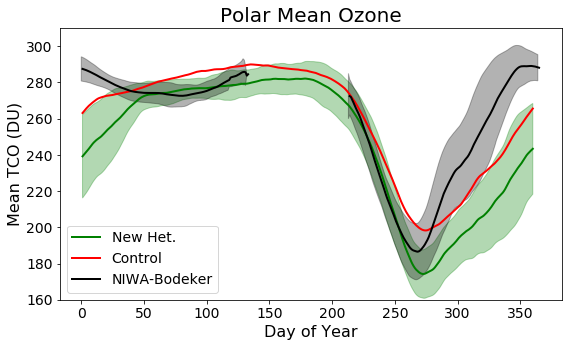

In [11]:
# Figure 5

from matplotlib.patches import Polygon

def running_mean(x,n) :
    n2 = (n-1)/2
    x1 = np.concatenate([np.full(n2, np.nan), x, np.full(n2, np.nan)])
    x1[x1==0] = np.nan
    x_out=[]
    for i, xn in enumerate(x) :
        x_out.append(np.mean(x1[i:(i+n)]))
        
    return x_out

def calc_clim(cube,cal) :
    ts = cube.copy()
    ts.data = running_mean(ts.data,21)
    yr1 = ts.coord('year').points[0]+1
    yr2 = ts.coord('year').points[-1]
    #print yr1, yr2
    constr1 = ir.Constraint(year=range(yr1,yr2))
    ts_ex = ts.extract(constr1)
    ts_yrs = np.reshape(ts_ex.data,[cal,-1], order='F')
    ts_mean = np.nanmean(ts_yrs, axis=1)
    ts_std = np.nanstd(ts_yrs, axis=1)   
    return ts_mean, ts_std

fig, ax = plt.subplots(figsize=(9,5))
lat_range = lambda cell: cell <= -65
constr = ir.Constraint(latitude=lat_range, year=range(1996-1,2002)+range(2003,2011))
o3_ex = clist[1].extract(constr)
ga = iris.analysis.cartography.area_weights(o3_ex)
bod_ex = bod_d.extract(constr)
ga_bod = iris.analysis.cartography.area_weights(bod_ex)

o3_newbr = clist[0].extract(constr).collapsed(['latitude','longitude'],ir.analysis.MEAN, weights = ga)
o3_cont = clist[1].extract(constr).collapsed(['latitude','longitude'],ir.analysis.MEAN, weights = ga)
o3_bod = bod_d.extract(constr).collapsed(['latitude','longitude'],ir.analysis.MEAN, weights = ga_bod)
iris.coord_categorisation.add_categorised_coord(o3_bod, 'leap', 'time', lambda coord, value: coord.units.num2date(value).month == 2 and coord.units.num2date(value).day == 29)
noleap = iris.Constraint(leap=False)
o3_bod = o3_bod.extract(noleap)


[newbr_mean, newbr_std] = calc_clim(o3_newbr,360)
[cont_mean, cont_std] = calc_clim(o3_cont,360)
[bod_mean, bod_std] = calc_clim(o3_bod,365)

plt.plot(np.arange(1,361),newbr_mean,label='New Het.',linewidth=2,color='g')
plt.plot(np.arange(1,361),cont_mean,label='Control',linewidth=2,color='r')
plt.plot(np.arange(1,366),bod_mean, label='NIWA-Bodeker',linewidth=2,color='k')

def plot_sd(m,sd,n,ax,c):
    x = np.concatenate([n,np.flip(n,0)])
    y = np.concatenate([np.array(m+sd),np.flip(np.array(m-sd),0)])
    xy =np.stack([x,y],1)
    p = Polygon(xy, closed=True, alpha=0.3 ,color=c)
    ax.add_patch(p)
    
plot_sd(newbr_mean,newbr_std,np.arange(1,361),ax,'g')
#plot_sd(cont_mean,cont_std,360,ax,'r')

if sum(np.isnan(bod_mean))>0 :
    i_start = [0]
    i_end = []
    for i, x in enumerate(bod_mean, 1) :
        if np.array_equal(np.isnan(bod_mean[i-1:i+1]),np.array([1,0])) :
            i_start.append(i)
        if np.array_equal(np.isnan(bod_mean[i-1:i+1]),np.array([0,1])) :
            i_end.append(i)
    i_end.append(i) 
    for i1, i2 in zip(i_start,i_end) :
        plot_sd(bod_mean[i1:i2],bod_std[i1:i2],np.arange(i1,i2),ax,'k')
else :    
    plot_sd(bod_mean,bod_std,np.arange(1,366),ax,'k')

plt.title('Polar Mean Ozone',fontsize=20)
plt.xlabel('Day of Year',fontsize=16)
plt.ylabel('Mean TCO (DU)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim([160,310])
plt.legend(fontsize=14)

plt.show()
#plt.savefig('figs/aw638_polar_o3clim.png',bbox_inches='tight')

In [14]:
# load temperature data
# model:
tlist = [] #monthly mean temperature
x = ir.load_cube(path+'/aw638/aw638_new_br_t_plev.nc')
tlist.append(x)
x = ir.load_cube(path+'/aw638/aw638_t_plev.nc')
tlist.append(x)

# ERA-interim
# data from: http://apps.ecmwf.int/datasets/data/interim-full-mnth/levtype=pl/
# 0.75 lat/lon resolution, pressure levels 100/70/50/30/20/10 hPa
def clean_callback(cube, field, filename):
    del cube.attributes['history']

t_era = ir.load('/nesi/nobackup/dennisonfw/ERA/*.nc', callback=clean_callback).concatenate_cube()
t_era.coord('latitude').guess_bounds()
t_era.coord('longitude').guess_bounds()
ir.coord_categorisation.add_month(t_era, 'time', name='month')
ir.coord_categorisation.add_year(t_era, 'time', name='year')

/home/dennisonfw/miniconda2/envs/notebk/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'pressure'.
  warnings.warn(msg.format(self.name()))
/home/dennisonfw/miniconda2/envs/notebk/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'pressure_level'.
  warnings.warn(msg.format(self.name()))


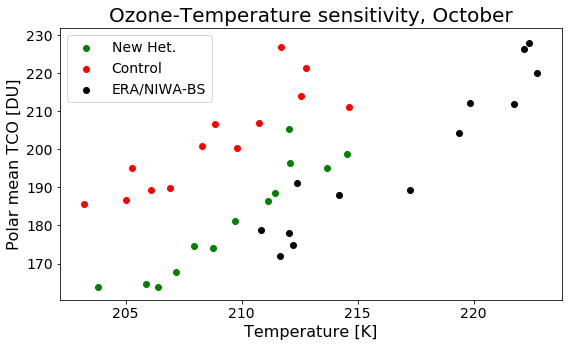

In [15]:
# Figure 6

mon = 'Oct'
lat_range = lambda cell: cell <= -65

fig, ax = plt.subplots(figsize=(9,5))
constr = ir.Constraint(latitude = lat_range, month= mon, year=range(1996,2002)+range(2003,2010))
pr_range = lambda cell: 10. <= cell <= 100.
c = ['g','r']
for ii, tcube in enumerate(tlist):
    t_ex = tcube.extract(constr & ir.Constraint(pressure=pr_range))
    grid_areas_t = iris.analysis.cartography.area_weights(t_ex)
    t_ts = t_ex.collapsed(['longitude','latitude','pressure'],
                          ir.analysis.MEAN, weights=grid_areas_t).data 
    o3_ex = mmlist[ii].extract(constr)
    grid_areas_o3 = iris.analysis.cartography.area_weights(o3_ex)
    o3_ts = o3_ex.collapsed(['longitude','latitude'],
                            ir.analysis.MEAN, weights=grid_areas_o3).data
    plt.scatter(t_ts,o3_ts,label=lab[ii],color=c[ii])


t_era_ex = t_era.extract(constr & ir.Constraint(pressure_level=pr_range))
ga_era = iris.analysis.cartography.area_weights(t_era_ex)
t_era_ts = t_era_ex.collapsed(['latitude','longitude','pressure_level'],ir.analysis.MEAN, weights=ga_era)

bod_ex = bod_m.extract(constr)
ga_bod = iris.analysis.cartography.area_weights(bod_ex)
bod_ts = bod_ex.collapsed(['latitude','longitude'],ir.analysis.MEAN, weights=ga_bod)

iplt.scatter(t_era_ts,bod_ts,label='ERA/NIWA-BS', color='k') 
plt.xticks(range(205,225,5))
plt.legend(fontsize=14) #
plt.xlabel('Temperature [K]',fontsize=16)
plt.ylabel('Polar mean TCO [DU]',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Ozone-Temperature sensitivity, '+mon+'ober', fontsize=20)

#plt.savefig('figs/aw638_o3_t_scatter_'+mon+'.png',bbox_inches='tight')
plt.show()

In [17]:
stash = {'O3':1,'ClO':42,'Cl2O2':43,'HBr':52,'HCl':992,'BrO':994,'BrONO2':48,'ClONO2':54}
mm = {'O3':48.,'ClO':51.45,'Cl2O2':102.9,'HBr':80.9,'HCl':36.46,'BrO':95.9,'BrONO2':141.9,'ClONO2':97.46}
sname = {v: k for k, v in stash.iteritems()}

In [18]:
items = sorted(stash.values())
mmrlist = []
nlist = []
for runname in runs :
    for item in items :
        cube = ir.load_cube('/nesi/nobackup/dennisonfw/output/netcdf/aw638/'+runname+'_'+sname[item]+'.nc')
        cube.remove_coord('forecast_reference_time')
        cube.remove_coord('forecast_period')
        cube.coord('level_height').points = cube.coord('level_height').points/1000.
        mmrlist.append(cube)
        nlist.append(sname[item])

<Figure size 432x288 with 0 Axes>

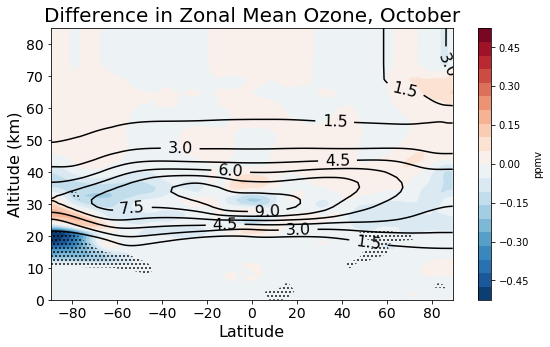

In [20]:
# Figure 7

from scipy import stats

plt.set_cmap('RdBu_r')
def plot_mmr(cube1,cube2,nspec,mm,mon) :
    constr = ir.Constraint(month=mon, year=range(1996,2010))
    mx = cube2.extract(constr).collapsed(['latitude',
                       'model_level_number','time'],ir.analysis.MAX).data
    if mm == 29.0:
        units = 'mol/sec'
        x= 1.0
    elif mx <= 1e-9 :
        units = 'pptv' 
        x = 1e12
    elif 1e-9 < mx <= 1e-6:
        units = 'ppbv'  
        x = 1e9
    else :   
        units = 'ppmv' 
        x = 1e6
       
    diff = (cube1-cube2 ) * x * 29.0 / mm
    m = diff.extract(constr)
    sd = m.collapsed(['time'],ir.analysis.STD_DEV)
    m = m.collapsed(['time'],ir.analysis.MEAN)
    
    dmin = abs(m.collapsed(['latitude','model_level_number'],ir.analysis.MIN).data)
    dmax = abs(m.collapsed(['latitude','model_level_number'],ir.analysis.MAX).data)
    dext = max(dmin,dmax)
    v = np.linspace(-dext,dext,21)
    iplt.contourf(m,v)
    cbar = plt.colorbar(label = units) 
    cbar.set_ticks(np.arange(-0.45,0.6,0.15))
    
    
    [t,p] = stats.ttest_ind(cube1.extract(constr).data,cube2.extract(constr).data,axis=0)
    pcube = sd.copy(data = p)
    thatch = iplt.contourf(pcube,[0,0.01,1000], hatches=['...',''], alpha=0)
    
    try :
        cs  = iplt.contour(cube2.extract(ir.Constraint(month=mon, year=range(1996,2010))).collapsed(['longitude','time'],
                           ir.analysis.MEAN) * x * 29.0 / mm  ,colors='k')
        plt.clabel(cs, inline=1, fontsize=16, fmt='%3.1f',)
    except:
        print ''
    if units == 'mol/sec' : 
        plt.ylim([0,40000])
           
    return p;
    
nspec = (len(mmrlist)/2)
spec_list = ['O3']
mth ='October'
for spec in spec_list :
    ii = nlist.index(spec)
    fig, ax = plt.subplots(figsize=(9,5))
    x_cont = mmrlist[ii+nspec]
    x_newbr = mmrlist[ii] 
    p = plot_mmr(x_newbr,x_cont,nspec,mm[nlist[ii]],mth[0:3])
    plt.title('Difference in Zonal Mean Ozone, '+mth, fontsize=20) 
    plt.xlabel('Latitude',fontsize=16)
    plt.ylabel('Altitude (km)',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show() 
    #plt.savefig('figs/aw638_zmO3_'+mth[0:3]+'.png',bbox_inches='tight')
               

In [21]:
stash = {r'O$_2$ + h$\nu$':101, r'HO$_2$ + NO':102, r'MeOO + NO':103, r'OH + HONO$_2$':104,
         r'Cl$_2$O$_2$ +h$\nu$':111, r'Br_O + Cl_O -> Br + OClO':112, 
         r'HO$_2$ + O$_3$':113, r'ClO + HO$_2$':114, r'BrO + HO$_2$':115, r'O(3P) + ClO':116,
         r'O(3P) + NO$_2$':117, r'O(3P) + HO$_2$':118, 
         r'O$_3$ + H':119, r'O(3P) + H':120, r'NO$_3$ + h$\nu$':121, r'O(1D) + H$_2$O':122,
         r'HO$_2$ + NO$_3$':123, r'OH + NO$_3$':124,
         r'NO$_3$ + HCHO':125, r'BrO + ClO':126, r'BrO + ClO -> BrCl + O$_2$':127,
         'NAT':218, r'ClONO$_2$ + HCl':260, r'ClONO$_2$ + H$_2$O':261, r'HOCl + HCl':262,
         r'N$_2$O$_5$ + H$_2$O':263, 'N$_2$O$_5$ + HCl':264,
         r'HOBr + HCl':265, r'BrONO$_2$ + HCl':266, r'BrONO$_2$ + H$_2$O':267, 
         r'HOBr + HBr':268, r'HOCl + HBr':269,
         r'ClONO$_2$ + HBr':270, r'BrONO$_2$ + HBr':271, r'N$_2$O$_5$ + HBr':272}
vname = {v: k for k, v in stash.iteritems()}

In [24]:
rxns = range(101,105)+[111]+range(113,127) 
rxn_list = []
fl_list = []
run_diff = ['_new_br',''] #
for run in  run_diff:
    for rxn in rxns :        
        x = ir.load_cube(path+'/aw638/'+run+'_'+str(rxn)+'.nc')
        x.remove_coord('forecast_period')
            
        fl_list.append(x*192.)
        rxn_list.append(vname[rxn])
        
plot_diff = ['_new_br','']
n_rxns = len(rxn_list)/len(run_diff)
ht_range = lambda cell: 12000. <= cell <= 24000.
lat_range = lambda cell: -90. <= cell <= -65.
tot_diff = []
tot1 = []

for ii, rxn in enumerate(rxns) :    
    diff  = (fl_list[run_diff.index(plot_diff[0])*n_rxns+ii].extract(ir.Constraint(year=range(1996,2010)))
           - fl_list[run_diff.index(plot_diff[1])*n_rxns+ii].extract(ir.Constraint(year=range(1996,2010)))) 
    constr = ir.Constraint(latitude = lat_range,level_height = ht_range)
    diff = diff.extract(constr).collapsed(['latitude','model_level_number'],ir.analysis.SUM)   
    tot_diff.append(diff.collapsed('time',ir.analysis.MEAN).data)

-2868.2763918250685


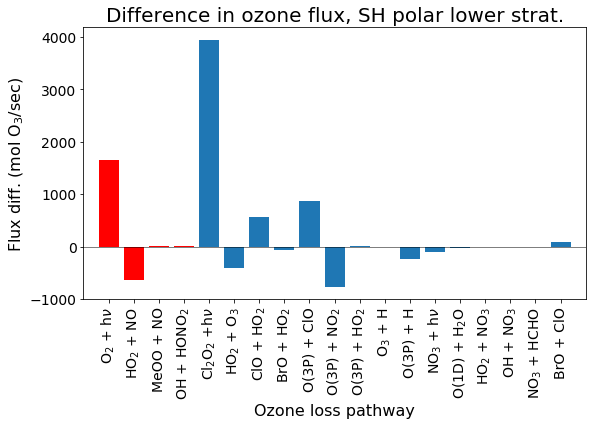

In [27]:
# Figure 8

fig, ax = plt.subplots(figsize=(9,5))
xax = range(0,n_rxns)
p = plt.bar(xax,tot_diff)
for ii in range(0,4) : p[ii].set_facecolor('r')
plt.xticks(xax, rxn_list, rotation='vertical')
plt.title('Difference in ozone flux, SH polar lower strat.',fontsize=20)
plt.ylabel(r'Flux diff. (mol O$_3$/sec)',fontsize=16)
plt.xlabel('Ozone loss pathway',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot([-2,20],[0,0],'k',linewidth=0.5)
plt.xlim([-1,19])
print  sum(tot_diff[:4]) - sum(tot_diff[4:])

plt.show()
#plt.savefig('figs/aw638_O3flux.png',bbox_inches='tight')

In [32]:
# Table 2

from math import log10, floor

rxns = range(260,273)
fhet = []
namehet = []

run_diff = ['_new_br',''] #
for run in  run_diff:
    for rxn in rxns :        
        x = ir.load_cube(path+'/aw638/'+run+'_'+str(rxn)+'.nc')
        x.remove_coord('forecast_reference_time')
        x.remove_coord('forecast_period')

        fhet.append(x*192.) # zonal sum
        namehet.append(vname[rxn])

n_rxns = len(namehet)/len(run_diff)

n_rxns = len(namehet)/len(run_diff)
ht_range = lambda cell: 10000. <= cell <= 90000.
lat_range = lambda cell: -90. <= cell <= 90.
het_tot_diff = []
het_tot_1=[]
het_tot_2=[]
for ii, rxn in enumerate(rxns) :    
    diff  = fhet[ii] - fhet[n_rxns+ii]
    constr = ir.Constraint(latitude = lat_range,level_height = ht_range)
    diff = diff.extract(constr).collapsed(['latitude','model_level_number'],ir.analysis.SUM)
    het_tot_diff.append(diff.collapsed('time',ir.analysis.MEAN).data)
    het_tot_1.append(fhet[ii].extract(constr).
                     collapsed(['latitude','model_level_number'],ir.analysis.SUM).
                     collapsed('time',ir.analysis.MEAN).data)
    het_tot_2.append(fhet[n_rxns+ii].extract(constr).
                     collapsed(['latitude','model_level_number'],ir.analysis.SUM).
                     collapsed('time',ir.analysis.MEAN).data)

def sigfig(x,n):
    if x<0:
        a = -1.
    else :
        a = 1.
    x =  round(abs(x), -int(floor(log10(abs(x)))) + (n - 1)) * a    
    return x


def fmt(n) :
    if n==0:
        n_fmt = '-'
    elif np.isinf(n):
        n_fmt = '-'
    else : 
        n_fmt = sigfig(n,3)
    
    return n_fmt
    

for ii, rxn in enumerate(rxns) :
    print '\chem{'+namehet[ii]+'}',' & ',fmt(het_tot_2[ii]),' & ',fmt(het_tot_1[ii]),' & ',fmt(het_tot_diff[ii]),' & ',fmt(het_tot_diff[ii]/het_tot_2[ii]*100),'\\\\'

 \chem{ClONO$_2$ + HCl}  &  468.0  &  747.0  &  279.0  &  59.6 \\
\chem{ClONO$_2$ + H$_2$O}  &  1300.0  &  1040.0  &  -266.0  &  -20.4 \\
\chem{HOCl + HCl}  &  1230.0  &  1190.0  &  -46.7  &  -3.78 \\
\chem{N$_2$O$_5$ + H$_2$O}  &  8180.0  &  7880.0  &  -296.0  &  -3.62 \\
\chem{N$_2$O$_5$ + HCl}  &  3.02  &  3.13  &  0.114  &  3.78 \\
\chem{HOBr + HCl}  &  -  &  22.9  &  22.9  &  - \\
\chem{BrONO$_2$ + HCl}  &  -  &  981.0  &  981.0  &  - \\
\chem{BrONO$_2$ + H$_2$O}  &  -  &  560.0  &  560.0  &  - \\
\chem{HOBr + HBr}  &  -  &  13.1  &  13.1  &  - \\
\chem{HOCl + HBr}  &  -  &  0.167  &  0.167  &  - \\
\chem{ClONO$_2$ + HBr}  &  -  &  0.209  &  0.209  &  - \\
\chem{BrONO$_2$ + HBr}  &  -  &  0.509  &  0.509  &  - \\
\chem{N$_2$O$_5$ + HBr}  &  -  &  0.000158  &  0.000158  &  - \\


/scale_wlg_persistent/filesets/home/dennisonfw/miniconda2/envs/notebk/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in divide


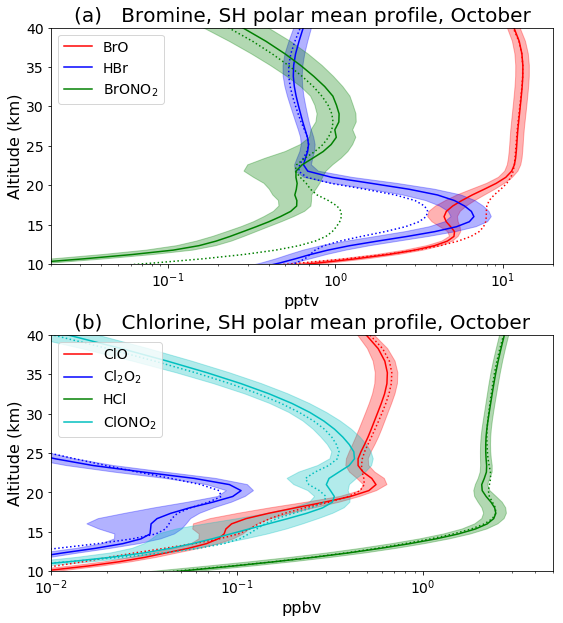

In [34]:
# Figure 9

def plot_model_profile(cube1,cube2,mth,mm,c,lab, ax) :
    lat_range = lambda cell: cell <=  -65.
    constr = ir.Constraint(latitude=lat_range, month=mth[0:3])
    
    
    prof1 = cube1.extract(constr) * 29. / mm
    ga = iris.analysis.cartography.area_weights(prof1)
    prof1 = prof1.collapsed('latitude',ir.analysis.MEAN, weights=ga)
    sd1 = prof1.collapsed('time',ir.analysis.STD_DEV)
    prof1 = prof1.collapsed('time',ir.analysis.MEAN)
    
    prof2 = cube2.extract(constr).collapsed(['latitude','time'],
                                  ir.analysis.MEAN, weights=ga) * 29. / mm   
    
    alt = prof1.coord('level_height').points
    
    x = np.concatenate([np.array(prof1.data+sd1.data),np.flip(np.array(prof1.data-sd1.data),0)])
    y = np.concatenate([alt,np.flip(alt,0)])
    xy =np.stack([x,y],1)
    p = Polygon(xy, closed=True, alpha=0.3 ,color=c)
    ax.add_patch(p)
     
    plt.plot(prof1.data,prof1.coord('level_height').points, label=lab, linestyle='-', color=c)
    plt.plot(prof2.data,prof2.coord('level_height').points, linestyle=':', color=c) 
    
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(9,10)) 
mn = 'October'
col = ['r','b','g','c','m','y']

plt.subplot(ax1)
spec_list = ['BrO','HBr','BrONO2']
labs = [r'BrO',r'HBr',r'BrONO$_2$']
for spec, c, lab in zip(spec_list,col,labs) : 
    ii = nlist.index(spec)
    plot_model_profile(mmrlist[ii]*1e12,mmrlist[ii+nspec]*1e12, mn, mm[spec], c, lab, ax1)

plt.ylim([10,40])
plt.ylabel('Altitude (km)',fontsize=16)
plt.xlim([2e-2,20])
plt.xlabel('pptv',fontsize=16)
plt.title('(a)   Bromine, SH polar mean profile, '+mn,fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xscale('log')
plt.legend(fontsize=14)

plt.subplot(ax2)
spec_list = ['ClO','Cl2O2','HCl','ClONO2']
labs = [r'ClO',r'Cl$_2$O$_2$',r'HCl',r'ClONO$_2$']
for spec, c, lab in zip(spec_list,col,labs) : 
    ii = nlist.index(spec)
    plot_model_profile(mmrlist[ii]*1e9, mmrlist[ii+nspec]*1e9, mn, mm[spec], c, lab, ax2)

plt.ylim([10,40])
plt.ylabel('Altitude (km)',fontsize=16)
plt.xlim([1e-2,5])
plt.xlabel('ppbv',fontsize=16)
plt.title('(b)   Chlorine, SH polar mean profile, '+mn,fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xscale('log')
plt.legend(loc='upper left', fontsize=14)

plt.subplots_adjust(hspace=0.3)

plt.show()
#plt.savefig('figs/aw638_prof_'+mn[0:3]+'.png',bbox_inches='tight')
